In [1]:
""" 
MIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb

The features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)
"""

' \nMIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb\n\nThe features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)\n'

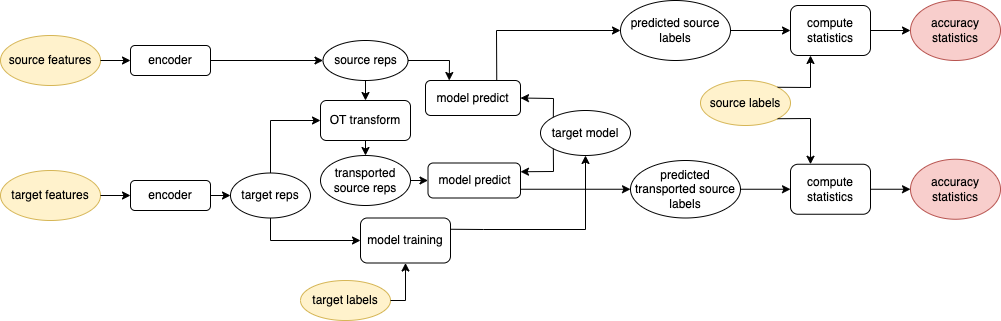

In [2]:
from IPython.display import Image
Image(filename='../../outputs/pipeline_figs/EHR_MIMIC_pipeline.png')

In [3]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

from common import *
from ast import literal_eval
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [4]:
""" 
Read in dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[1, 5, 9]",530460.0,LEG PAIN,0
173633,EMERGENCY,F,[9],574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[26, 27]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,[31],1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[27, 26, 34, 35]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[47, 34, 31]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[103, 47, 45, 31, 35, 430]",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[44, 103, 47, 250, 62, 45, 35]",692940.0,STROKE;TELEMETRY,0


In [5]:
def update_codes(df):
    """ 
    Update code in dataframe, the new code starts from 0.
    We use -1 to denote NA code in later analysis

    returns
        - a new dataframe with the updated codes
        - total number of unique codes in df
    """
    new_code_dict = {} # mapping from old code to new code
    for index, row in df.iterrows():
        cur_codes = row['ICD codes']
        new_codes = []
        for code in cur_codes:
            if code not in new_code_dict:
                new_code_dict[code] = len(new_code_dict) # add a new entry
            new_codes.append(new_code_dict[code])
        df.at[index, 'ICD codes'] = new_codes
    return df, len(new_code_dict)


In [6]:
def get_codes_labels(df):
    """ 
    Get the list of codes and labels for dataframe df
    """
    
    codes = []
    labels = []
    for index, row in df.iterrows():
        codes.append(row['ICD codes'])
        labels.append(row['label'])
    return codes, labels

In [7]:
def gen_features(codes, num_codes):
    """ 
    Generate features from df

    :param list[list[int]] codes: list of codes (per patient)
    :param int num_codes: total number of codes
    """

    # Prepare target
    features = np.empty(shape=[len(codes), num_codes])
    feature_index = 0
    for cur_codes in codes:
        code_ind = np.zeros(num_codes)
        for code in cur_codes:
            code_ind[code] += 1
        features[feature_index] = code_ind
        feature_index += 1

    return features


In [8]:
def select_codes(codes, labels, num):
    """ 
    Select a subset of codes with equal amount (num) of label 0s and 1s 

    :param list[list[int]] codes: the list of codes, per patient
    :param list[int] labels: list of labels (0s and 1s)
    :param int num: number of samples to select for 0s and 1s
    
    returns the selected codes and labels
    """
    label_1_indices = []
    label_0_indices = []
    for i in range(len(labels)):
        if labels[i] == 0:
            label_0_indices.append(i)
        else:
            label_1_indices.append(i)

    # print("label_1 length is:", len(label_1_indices))
    # print("label_0 length is:", len(label_0_indices))
    label_1_select_indices = random.sample(label_1_indices, num)
    label_0_select_indices = random.sample(label_0_indices, num)
    
    selected_codes = [codes[i] for i in np.concatenate((label_1_select_indices, label_0_select_indices), axis=0)]
    selected_labels = [labels[i] for i in np.concatenate((label_1_select_indices, label_0_select_indices), axis=0)]
    return selected_codes, selected_labels

    


In [20]:
""" 
Prepare dataframes for training and test
"""

def prepare_dataset(n_components=5):
    print("=== preparing datasets ===")
    admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})

    admid_diagnosis_df, num_codes = update_codes(admid_diagnosis_df)

    female_emergency_df = admid_diagnosis_df[(admid_diagnosis_df['gender']== 'F') & (admid_diagnosis_df['adm_type'] == 'EMERGENCY')]
    female_elective_df = admid_diagnosis_df[(admid_diagnosis_df['gender']== 'F') & (admid_diagnosis_df['adm_type'] == 'ELECTIVE')]
    male_emergency_df = admid_diagnosis_df[(admid_diagnosis_df['gender']== 'M') & (admid_diagnosis_df['adm_type'] == 'EMERGENCY')]
    male_elective_df = admid_diagnosis_df[(admid_diagnosis_df['gender']== 'M') & (admid_diagnosis_df['adm_type'] == 'ELECTIVE')]

    # print("female_emergency_df shape is:", female_emergency_df.shape)
    # print("female_emergency 1 count is:", female_emergency_df[(female_emergency_df['label']== 1)].shape[0])
    # print("female_elective_df shape is:", female_elective_df.shape)
    # print("female_elective 1 count is:", female_elective_df[(female_elective_df['label']== 1)].shape[0])
    # print("male_emergency_df shape is:", male_emergency_df.shape)
    # print("male_emergency 1 count is:", male_emergency_df[(male_emergency_df['label']== 1)].shape[0])
    # print("male_elective_df shape is:", male_elective_df.shape)
    # print("male_elective 1 count is:", male_elective_df[(male_elective_df['label']== 1)].shape[0])

    female_emergency_codes, female_emergency_labels = get_codes_labels(female_emergency_df)
    female_elective_codes, female_elective_labels = get_codes_labels(female_elective_df)
    male_emergency_codes, male_emergency_labels = get_codes_labels(male_emergency_df)
    male_elective_codes, male_elective_labels = get_codes_labels(male_elective_df)

    male_elective_num = 60
    male_emergency_num = 60
    male_emergency_target_num = 10
    female_emergency_num = 50

    train_male_elective_codes, train_male_elective_labels = select_codes(male_elective_codes, male_elective_labels, male_elective_num)
    train_male_elective_features = gen_features(train_male_elective_codes, num_codes)
    # print("train_male_elective_features shape is:", train_male_elective_features.shape)

    target_male_emergency_codes, target_male_emergency_labels = select_codes(male_emergency_codes, male_emergency_labels, male_emergency_target_num)
    target_male_emergency_features = gen_features(target_male_emergency_codes, num_codes)
    target_male_emergency_pca = PCA(n_components=n_components)
    target_male_emergency_reps = target_male_emergency_pca.fit_transform(target_male_emergency_features)

    train_male_emergency_codes, train_male_emergency_labels = select_codes(male_emergency_codes, male_emergency_labels, male_emergency_num)
    train_male_emergency_features = gen_features(train_male_emergency_codes, num_codes)

    train_female_emergency_codes, train_female_emergency_labels = select_codes(female_emergency_codes, female_emergency_labels, female_emergency_num)
    train_female_emergency_features = gen_features(train_female_emergency_codes, num_codes)

    # print("male_elective_features shape is:", train_male_elective_features.shape)
    # print("male_emergency_features shape is:", train_male_emergency_features.shape)
    # print("female_emergency_features shape is:", train_female_emergency_features.shape)

    test_male_elective_num = 20
    test_male_emergency_num = 20
    test_male_elective_codes, test_male_elective_labels = select_codes(male_elective_codes, male_elective_labels, test_male_elective_num)
    test_male_elective_features = gen_features(test_male_elective_codes, num_codes)
    # print("test_male_elective_features shape is:", test_male_elective_features.shape)

    test_male_emergency_codes, test_male_emergency_labels = select_codes(male_emergency_codes, male_emergency_labels, test_male_emergency_num)
    test_male_emergency_features = gen_features(test_male_emergency_codes, num_codes)

    # test_features = test_male_emergency_features
    # test_labels = test_male_emergency_labels

    test_features = np.concatenate((test_male_emergency_features, test_male_elective_features), axis=0)
    test_labels = np.concatenate((test_male_emergency_labels, test_male_elective_labels), axis=0)

    # print("test_features shape is:", test_features.shape)
    test_pca = PCA(n_components=n_components)
    test_reps = test_pca.fit_transform(test_features)
    
    return train_male_elective_features, train_male_elective_labels, \
        train_male_emergency_features, train_male_emergency_labels, \
        train_female_emergency_features, train_female_emergency_labels, \
        test_reps, test_labels, target_male_emergency_reps
        


In [21]:
""" 
What if train by only male elective samples
"""

def train_male_elective(train_male_elective_features, train_male_elective_labels, test_reps, test_labels, n_components):
    male_elective_pca = PCA(n_components=n_components)

    train_male_reps = male_elective_pca.fit_transform(train_male_elective_features)
    print("train_male_reps shape is:", train_male_reps.shape)
    clf = SVC()
    clf.fit(train_male_reps, train_male_elective_labels)
    train_male_preds = clf.predict(train_male_reps)
    test_preds = clf.predict(test_reps)
    train_acc = accuracy_score(train_male_elective_labels, train_male_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    return train_acc, test_acc



In [22]:
""" 
What if we train the clf by both emergency and elective males? 

Conclusion: adding male emergency examples to the training set helps with test accuracy

"""

def train_male_elective_male_emergency(train_male_elective_features, train_male_elective_labels, \
                                       train_male_emergency_features, train_male_emergency_labels, \
                                        test_reps, test_labels, n_components):
    male_emergency_elective_pca = PCA(n_components=n_components)
    train_male_features = np.concatenate((train_male_elective_features, train_male_emergency_features), axis=0)
    train_male_labels = np.concatenate((train_male_elective_labels, train_male_emergency_labels), axis=0)
    train_male_reps = male_emergency_elective_pca.fit_transform(train_male_features)

    clf = SVC()
    clf.fit(train_male_reps, train_male_labels)
    train_male_preds = clf.predict(train_male_reps)
    train_acc = accuracy_score(train_male_labels, train_male_preds)
    test_preds = clf.predict(test_reps)
    test_acc = accuracy_score(test_labels, test_preds)
    return train_acc, test_acc


In [95]:
n_components = 10
train_male_elective_features, train_male_elective_labels, \
    train_male_emergency_features, train_male_emergency_labels, \
    train_female_emergency_features, train_female_emergency_labels, \
    test_reps, test_labels, target_male_emergency_reps = prepare_dataset(n_components)

train_acc_1, test_acc_1 = train_male_elective(train_male_elective_features, train_male_elective_labels, test_reps, test_labels, n_components)
train_acc_2, test_acc_2 = train_male_elective_male_emergency(train_male_elective_features, train_male_elective_labels, \
                            train_male_emergency_features, train_male_emergency_labels, \
                            test_reps, test_labels, n_components)
print(train_acc_1, test_acc_1)
print(train_acc_2, test_acc_2)

=== preparing datasets ===
train_male_reps shape is: (120, 10)
0.9 0.525
0.9041666666666667 0.3875


In [32]:
""" 
What if we train the clf by elective males and emergency females

TODO: why do not train male elective and female emergency using one pca?
"""

def train_male_elective_female_emergency(train_male_elective_features, train_male_elective_labels, \
                                         train_female_emergency_features, train_female_emergency_labels, \
                                        test_reps, test_labels, n_components):
    female_pca = PCA(n_components=n_components)
    train_female_emergency_reps = female_pca.fit_transform(train_female_emergency_features)

    male_elective_pca = PCA(n_components=n_components)
    train_male_elective_reps = male_elective_pca.fit_transform(train_male_elective_features)

    aug_train_reps = np.concatenate((train_male_elective_reps, train_female_emergency_reps), axis=0)
    print("aug_train_reps shape is:", aug_train_reps.shape)
    aug_train_labels = np.concatenate((train_male_elective_labels, train_female_emergency_labels), axis=0)

    aug_clf = SVC()
    aug_clf.fit(aug_train_reps, aug_train_labels)
    aug_train_male_preds = aug_clf.predict(aug_train_reps)
    aug_test_preds = aug_clf.predict(test_reps)

    train_acc = accuracy_score(aug_train_labels, aug_train_male_preds)
    test_acc = accuracy_score(test_labels, aug_test_preds)
    return train_acc, test_acc



In [76]:
""" 
What if we train the clf by elective males and transported emergency females

Conclusion:
"""

def train_male_elective_trans_female_emergency(train_male_elective_features, train_male_elective_labels, \
                                               train_female_emergency_features, train_female_emergency_labels, \
                                                test_reps, test_labels, target_male_emergency_reps, n_components):

    # OT
    
    train_male_elective_pca = PCA(n_components=n_components)
    train_male_elective_reps = train_male_elective_pca.fit_transform(train_male_elective_features)

    female_pca = PCA(n_components=n_components)
    train_female_emergency_reps = female_pca.fit_transform(train_female_emergency_features)
    ot_emd = ot.da.SinkhornTransport(reg_e=1e-1)
    trans_train_female_emergency_reps = ot_emd.fit_transform(Xs=train_female_emergency_reps, Xt=target_male_emergency_reps)

    trans_aug_train_reps = np.concatenate((train_male_elective_reps, trans_train_female_emergency_reps), axis=0)
    trans_aug_train_labels = np.concatenate((train_male_elective_labels, train_female_emergency_labels), axis=0)

    print("trans_aug_train_reps shape is:", trans_aug_train_reps.shape)
    trans_aug_clf = SVC()
    trans_aug_clf.fit(trans_aug_train_reps, trans_aug_train_labels)
    trans_aug_test_preds = trans_aug_clf.predict(test_reps)

    trans_aug_train_preds = trans_aug_clf.predict(trans_aug_train_reps)
    train_acc = accuracy_score(trans_aug_train_labels, trans_aug_train_preds)
    test_acc = accuracy_score(test_labels, trans_aug_test_preds)
    # print(trans_aug_test_preds)
    return train_acc, test_acc

In [77]:
# admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
# train_male_elective_features, train_male_elective_labels, \
#         train_male_emergency_features, train_male_emergency_labels, \
#         train_female_emergency_features, train_female_emergency_labels, \
#         test_reps, test_labels = prepare_dataset(admid_diagnosis_df)

In [78]:
# train_male_acc, test_male_acc = train_male_elective(train_male_elective_features, train_male_elective_labels, test_reps, test_labels)
# train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc = train_male_elective_male_emergency(train_male_elective_features, train_male_elective_labels, \
#                                        train_male_emergency_features, train_male_emergency_labels, \
#                                         test_reps, test_labels)
# train_male_elective_female_emergency_acc, test_male_elective_female_emergency_acc = train_male_elective_female_emergency(train_male_elective_features, train_male_elective_labels, \
#                                          train_female_emergency_features, train_female_emergency_labels, \
#                                         test_reps, test_labels)
# train_male_elective_trans_female_emergency_acc, test_male_elective_trans_female_emergency_acc = train_male_elective_trans_female_emergency(train_male_elective_features, train_male_elective_labels, \
#                                                train_female_emergency_features, train_female_emergency_labels, \
#                                                 test_reps, test_labels)

In [79]:
# print(train_male_acc, test_male_acc)
# print(train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc)
# print(train_male_elective_female_emergency_acc, test_male_elective_female_emergency_acc)
# print(train_male_elective_trans_female_emergency_acc, test_male_elective_trans_female_emergency_acc)

In [90]:
def entire_proc(n_components = 5):
    train_male_elective_features, train_male_elective_labels, \
            train_male_emergency_features, train_male_emergency_labels, \
            train_female_emergency_features, train_female_emergency_labels, \
            test_reps, test_labels, target_male_emergency_reps = prepare_dataset(n_components=n_components)
    train_male_acc, test_male_acc = train_male_elective(train_male_elective_features, train_male_elective_labels, test_reps, test_labels, n_components)
    train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc = train_male_elective_male_emergency(train_male_elective_features, train_male_elective_labels, \
                                        train_male_emergency_features, train_male_emergency_labels, \
                                            test_reps, test_labels, n_components)

    train_male_elective_female_emergency_acc, test_male_elective_female_emergency_acc = train_male_elective_female_emergency(train_male_elective_features, train_male_elective_labels, \
                                            train_female_emergency_features, train_female_emergency_labels, \
                                            test_reps, test_labels, n_components)
    train_male_elective_trans_female_emergency_acc, test_male_elective_trans_female_emergency_acc = train_male_elective_trans_female_emergency(train_male_elective_features, train_male_elective_labels, \
                                            train_female_emergency_features, train_female_emergency_labels, \
                                            test_reps, test_labels, target_male_emergency_reps, n_components)
    print(train_male_acc, test_male_acc)
    print(train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc)
    print(train_male_elective_female_emergency_acc, test_male_elective_female_emergency_acc)
    print(train_male_elective_trans_female_emergency_acc, test_male_elective_trans_female_emergency_acc)
    return train_male_acc, test_male_acc, train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc, \
        train_male_elective_female_emergency_acc, test_male_elective_female_emergency_acc, \
        train_male_elective_trans_female_emergency_acc, test_male_elective_trans_female_emergency_acc

In [81]:
# admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
# n_components = 10
# train_male_elective_features, train_male_elective_labels, \
#         train_male_emergency_features, train_male_emergency_labels, \
#         train_female_emergency_features, train_female_emergency_labels, \
#         test_reps, test_labels, target_male_emergency_reps = prepare_dataset(admid_diagnosis_df, n_components=n_components)
# train_male_acc, test_male_acc = train_male_elective(train_male_elective_features, train_male_elective_labels, test_reps, test_labels, n_components)
# train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc = train_male_elective_male_emergency(train_male_elective_features, train_male_elective_labels, \
#                                     train_male_emergency_features, train_male_emergency_labels, \
#                                         test_reps, test_labels, n_components)

In [82]:
# train_male_acc, test_male_acc, train_male_elective_male_emergency_acc, test_male_elective_male_emergency_acc

In [91]:
entire_proc()

=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.8 0.3875
0.8166666666666667 0.4875
0.7772727272727272 0.4625
0.7181818181818181 0.4


(0.8,
 0.3875,
 0.8166666666666667,
 0.4875,
 0.7772727272727272,
 0.4625,
 0.7181818181818181,
 0.4)

In [92]:
def run_multi_proc(n_components = 5, iteration = 10):
    res = np.empty(shape=[iteration, 8])
    for i in range(iteration):
        cur_res = \
            entire_proc()
        res[i] = cur_res
    res_df = pd.DataFrame(res, columns = ['train_male_acc', 'test_male_acc', 'train_male_elective_male_emergency_acc', 'test_male_elective_male_emergency_acc', \
        'train_male_elective_female_emergency_acc', 'test_male_elective_female_emergency_acc', \
        'train_male_elective_trans_female_emergency_acc', 'test_male_elective_trans_female_emergency_acc'])
    res_df.to_csv("../../outputs/mimic/score.txt")
    return res



In [93]:
res = run_multi_proc(n_components = 10, iteration=20)

=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.7833333333333333 0.4625
0.8333333333333334 0.5625
0.7863636363636364 0.5625
0.7181818181818181 0.425
=== preparing datasets ===


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.7833333333333333 0.675
0.8125 0.5125
0.7772727272727272 0.525
0.7272727272727273 0.575
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.8333333333333334 0.65
0.8666666666666667 0.525
0.8363636363636363 0.7
0.8227272727272728 0.675
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.8166666666666667 0.625
0.8333333333333334 0.55
0.8181818181818182 0.6625
0.7863636363636364 0.6625
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.875 0.4125
0.8416666666666667 0.4375
0.7909090909090909 0.4875
0.7863636363636364 0.4375
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.8083333333333333 0.45
0.8416666666666667 0.4625
0.7772727272727272 0.55
0.740909090909091 0.5375
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.825 0.55
0.8 0.575
0.7772727272727272 0.6
0.7863636363636364 0.6
=== preparing datasets ===
train_male_reps shape is: (120, 5)
aug_train_reps shape is: (220, 5)
trans_aug_train_reps shape is: (220, 5)
0.8416666666666667 0.35
0.8375 0.35
0.759090909090909 0.35
0.7545454545454545 0.3875


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [89]:
print(res)

[[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
